This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [25]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj01'
roi='V3'
voxels='pRFcenter'
stim_class='forward-spiral'

# Eccentricity bin information

In [21]:
e1, e2=0.5, 4
enum='log3'
enum_range=range(3) if enum=='log3' else range(enum)
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Load betas and experimental design information

In [36]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFcenter_tavg-False.csv'))
#subj_df = subj_df.query('~names.str.contains("intermediate").values')


In [37]:
subj_df

,image_idx,stim_idx,w_r,w_a,phase,class_idx,phase_idx,names,freq_lvl,voxel,...,eccentricity,angle,size,visualrois,vroinames,eccrois,local_sf,local_ori,hemi,sub
0,105,0,0.0,6.0,0.000000,0,0,pinwheel,0,1,...,4.135467,5.850342,2.123012,6.0,V3,4.0,0.230912,1.137953,lh,subj01
1,105,0,0.0,6.0,0.000000,0,0,pinwheel,0,1,...,4.135467,5.850342,2.123012,6.0,V3,4.0,0.230912,1.137953,lh,subj01
2,105,0,0.0,6.0,0.000000,0,0,pinwheel,0,2,...,3.343621,5.866106,1.541623,6.0,V3,4.0,0.285597,1.153717,lh,subj01
3,105,0,0.0,6.0,0.000000,0,0,pinwheel,0,2,...,3.343621,5.866106,1.541623,6.0,V3,4.0,0.285597,1.153717,lh,subj01
4,105,0,0.0,6.0,0.000000,0,0,pinwheel,0,3,...,3.172303,5.713500,1.506241,6.0,V3,4.0,0.301021,1.001111,lh,subj01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597627,216,111,14.0,-34.0,4.712389,27,6,mixtures,3,5420,...,2.907010,0.916491,61.154491,5.0,V3,5.0,2.013084,2.877895,rh,subj01
597628,216,111,14.0,-34.0,4.712389,27,6,mixtures,3,5467,...,3.422519,2.636247,1.581276,5.0,V3,5.0,1.709868,1.456058,rh,subj01
597629,216,111,14.0,-34.0,4.712389,27,6,mixtures,3,5467,...,3.422519,2.636247,1.581276,5.0,V3,5.0,1.709868,1.456058,rh,subj01
597630,216,111,14.0,-34.0,4.712389,27,6,mixtures,3,5511,...,3.904501,4.324888,0.036768,5.0,V3,5.0,1.498797,0.003106,rh,subj01


# 1. Binning

In [38]:
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
bin_df = subj_df.query('~names.str.contains("mixtures").values')
bin_df = tuning.summary_stat_for_ecc_bin(bin_df,
                                       to_group=['sub','names', 'vroinames','ecc_bin','freq_lvl'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

In [39]:
bin_df

,sub,names,vroinames,ecc_bin,freq_lvl,betas,local_sf
0,subj01,annulus,V3,0.5-1.0 deg,0,1.690123,1.361745
1,subj01,annulus,V3,0.5-1.0 deg,1,1.732465,2.496532
2,subj01,annulus,V3,0.5-1.0 deg,2,1.673435,4.539149
3,subj01,annulus,V3,0.5-1.0 deg,3,2.163738,8.397425
4,subj01,annulus,V3,0.5-1.0 deg,4,2.419990,15.660063
...,...,...,...,...,...,...,...
67,subj01,reverse spiral,V3,2.0-4.0 deg,1,2.224973,0.570768
68,subj01,reverse spiral,V3,2.0-4.0 deg,2,2.057163,1.141536
69,subj01,reverse spiral,V3,2.0-4.0 deg,3,2.384259,2.119996
70,subj01,reverse spiral,V3,2.0-4.0 deg,4,2.106973,3.995377


## Sanity check: Datapoints only

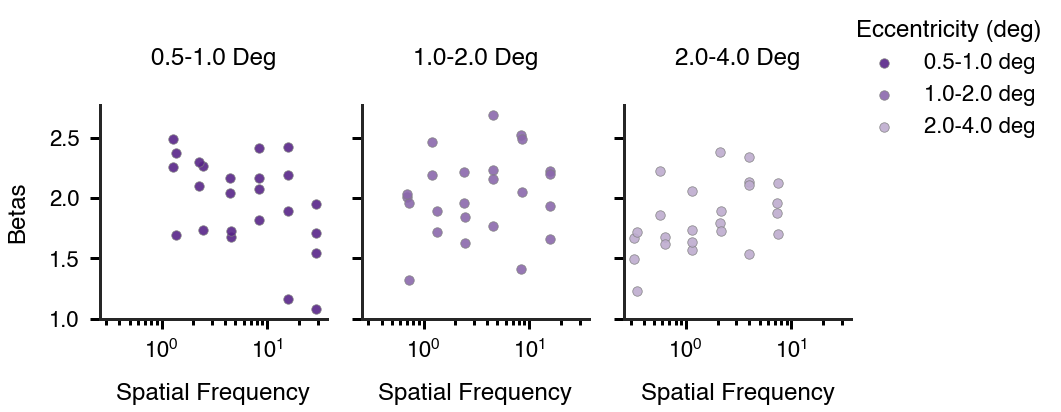

In [40]:
bins_to_plot = bin_labels #[bin_labels[k] for k in [0,3,-1]] 
vis1D.plot_datapoints(bin_df.query('ecc_bin in @bins_to_plot'), 
                      'local_sf', 'betas', hue='ecc_bin', hue_order=bins_to_plot, 
                      col='ecc_bin', col_order=bins_to_plot, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=[ecc_colors[k] for k in bins_to_plot])

# 2. Fitting log Gaussian curves for every eccentricity bin

In [68]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 
